In [1]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyarrow.parquet as pq
import seaborn as sns
import pandas as pd
import re

In [2]:
df_steam_games = pq.read_table('../data2/steam_games_compr.parquet').to_pandas()

# Elimino las filas del dataframe que poseen valores nulos en todas sus entradas
df_steam_games = df_steam_games.dropna(how='all')

In [3]:
# Convierte las listas en la columnas en una cadena separada por comas
df_steam_games['genres'] = df_steam_games['genres'].apply(lambda x: str(x).replace("[", "").replace("]", ""))
df_steam_games['tags'] = df_steam_games['tags'].apply(lambda x: str(x).replace("[", "").replace("]", ""))
df_steam_games['specs'] = df_steam_games['specs'].apply(lambda x: str(x).replace("[", "").replace("]", ""))

In [4]:
# Separo las listas y agrego una fila por cada valor
df_steam_games['genres'] = df_steam_games['genres'].str.split(', ')
df_steam_games = df_steam_games.explode('genres')
df_steam_games['genres'] = df_steam_games['genres'].apply(lambda x: str(x).replace("'", ""))

In [5]:
# Separa la cadena por comas y agrego una fila por cada valor individual
df_steam_games['tags'] = df_steam_games['tags'].str.split(', ')
df_steam_games = df_steam_games.explode('tags')
df_steam_games['tags'] = df_steam_games['tags'].apply(lambda x: str(x).replace("'", ""))

In [6]:
# Separa la cadena por comas y agrego una fila por cada valor individual
df_steam_games['specs'] = df_steam_games['specs'].str.split(', ')
df_steam_games = df_steam_games.explode('specs')
df_steam_games['specs'] = df_steam_games['specs'].apply(lambda x: str(x).replace("'", ""))

In [7]:
df_steam_games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
88310,Kotoshiro,Action,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,Strategy,http://steamcommunity.com/app/761140/reviews/?...,Single-player,4.99,False,761140.0,Kotoshiro
88310,Kotoshiro,Action,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,Action,http://steamcommunity.com/app/761140/reviews/?...,Single-player,4.99,False,761140.0,Kotoshiro
88310,Kotoshiro,Action,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,Indie,http://steamcommunity.com/app/761140/reviews/?...,Single-player,4.99,False,761140.0,Kotoshiro


In [8]:
# Elimino las filas en donde la columna price es nulo
df_steam_games.dropna(subset=['price'], inplace=True)

# Elimino las filas en donde la columna id es nulo
df_steam_games.dropna(subset=['id'], inplace=True)

In [9]:
# Selecciono el año de la columna release_date y la elimino
df_steam_games['anio'] = df_steam_games['release_date'].str.extract(r'(\d{4})')
df_steam_games.drop('release_date', axis=1, inplace=True)

In [10]:
# Verifico los outliers de año
df_steam_games[df_steam_games['anio'] > '2030'].shape[0]

0

In [11]:
df_steam_games.reset_index(drop=True, inplace=True)

In [12]:
# Elimino las columnas innecesarias
columnas = ['title','url','reviews_url','early_access']
df_steam_games.drop(columns=columnas, axis=1, inplace=True)

In [13]:
# Lleno los nulos de 'developer' con el valor correspondiente de 'publisher'.

publisher = pd.Series(df_steam_games['publisher'])
developer = pd.Series(df_steam_games['developer'])

for i in range(len(publisher)):
  if developer[i] is None:
    developer[i] = publisher[i]
  else:
    continue

df_steam_games['developer'] = developer

In [14]:
# Elimino la columna 'publisher'
df_steam_games.drop(columns = ['publisher'],axis=1,inplace=True)

In [15]:
# Elimino las filas donde 'anio' es nulo
df_steam_games.dropna(subset=['anio'], inplace=True)

# Convierto 'anio' a tipo integer
df_steam_games['anio'] = df_steam_games['anio'].astype(int)

# Convierto 'id' a tipo integer
df_steam_games['id'] = df_steam_games['id'].astype(int)

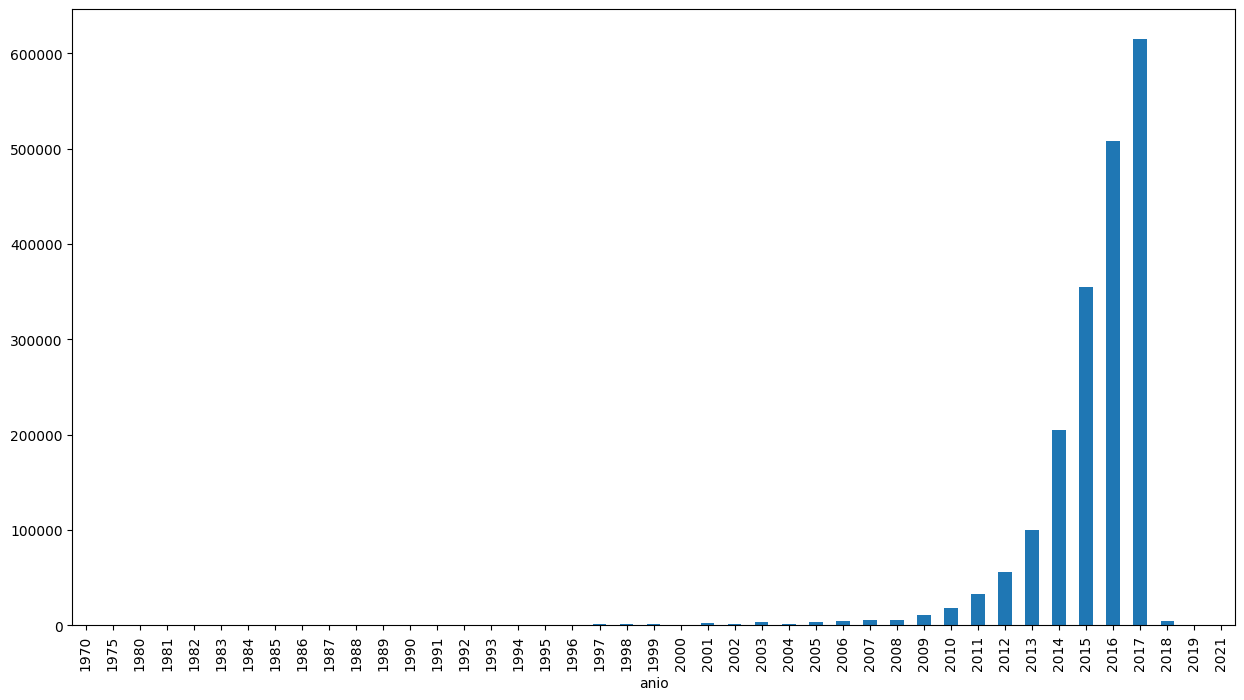

In [16]:
# Verifico la distribución de los años
df_steam_games['anio'].value_counts().sort_index().plot(kind='bar', figsize=(15, 8))
plt.show()

In [17]:
# Tratamiento de la columna 'price'

# Asigno valor 0.0 a las filas de 'price' que contienen la palabra 'free'
df_steam_games.loc[df_steam_games['price'].str.contains(r'\bfree\b', case=False, regex=True), 'price'] = '0.0'

# Extraigo el precio de las filas que contienen mezcla de letras y números
# Elimino las filas que no contengan información numérica
df_steam_games['price'] = df_steam_games['price'].str.extract(r'(\d+.\d+)')

# Elimino las filas de 'price' que contienen valores nulos
df_steam_games.dropna(subset=['price'], inplace=True)

# Convierto la columna a tipo float
df_steam_games['price'] = df_steam_games['price'].astype(float)

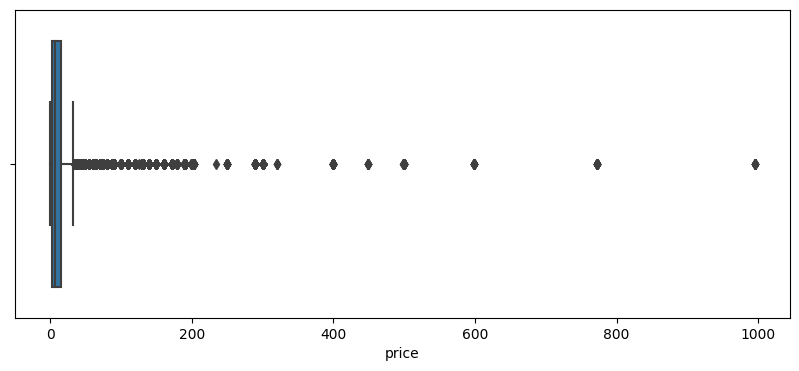

In [18]:
# Realizo un boxplot para ver la distribución de 'price'

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=df_steam_games['price'], ax=ax)
plt.show()

In [19]:
q1 = df_steam_games['price'].quantile(0.25)
q3 = df_steam_games['price'].quantile(0.75)
iqr = q3 - q1

In [21]:
# Precios que estén por fuera del siguiente intervalo son considerados outliers
(q1 - 1.5 * iqr), (q3 + 1.5 * iqr)

# Pero, basado en mi experiencia, hay juegos que puede llegar a costar $200.
# Por dicho motivo, imputaré solo los precios mayores a $200

(-15.01, 32.99)

In [24]:
# Identifico precios que sean mayores a 200.0 y los reemplazo con la mediana
df_steam_games.loc[df_steam_games['price'] > 200.0, 'price'] = df_steam_games['price'].median()

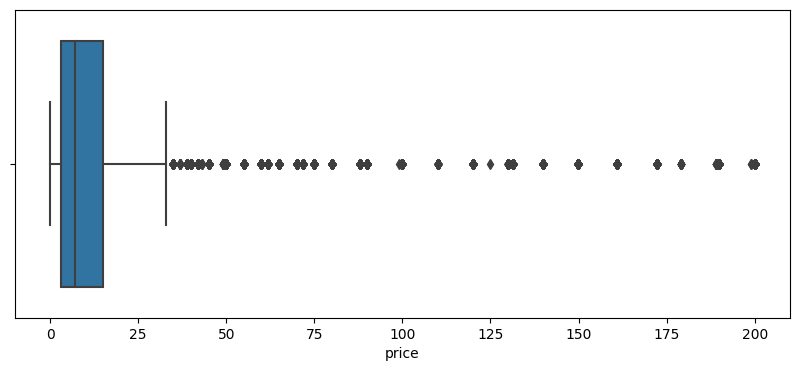

In [25]:
# Realizo un boxplot para ver la distribución de 'price' sin outliers
# Teniendo en cuenta que pueden haber juegos que valgan hasta $200

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=df_steam_games['price'], ax=ax)
plt.show()

In [26]:
def limpiar_y_convertir_a_minusculas(df):
    # Lista de caracteres especiales a reemplazar
    caracteres_especiales = ['-', '!', '¡', '?', '¿', '"', "'", ',', '&', "''", '_', '[', ']', ';', '(', ')','  ']

    for caracter in caracteres_especiales:
        df = df.apply(lambda x: x.str.replace(caracter, '') if x.dtype == "object" else x)

    df = df.apply(lambda x: x.astype(str).str.lower() if x.dtype == "object" else x)

    return df

In [21]:
df_steam_games = limpiar_y_convertir_a_minusculas(df_steam_games)
df_steam_games.head(3)

,genres,app_name,tags,specs,price,id,developer,anio
0,action,lost summoner kitty,strategy,singleplayer,4.99,761140,kotoshiro,2018
1,action,lost summoner kitty,action,singleplayer,4.99,761140,kotoshiro,2018
2,action,lost summoner kitty,indie,singleplayer,4.99,761140,kotoshiro,2018


### Ahora, realizo una nube de palabra de las columnas 'app_name', 'tags' y 'specs'

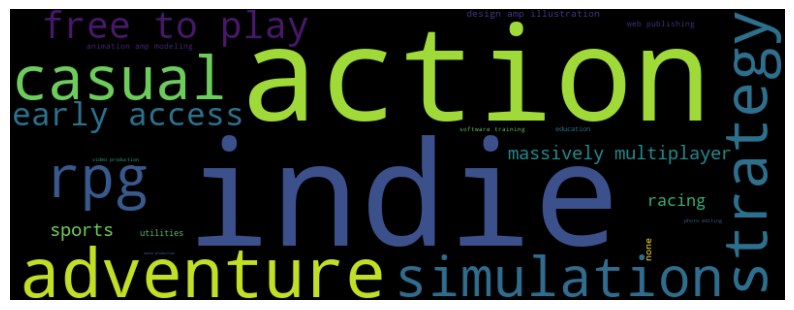

In [22]:
# Cuenta la frecuencia de cada género
frecuencia_genero = df_steam_games['genres'].value_counts()

# Crea la nube de palabras
wordcloud = WordCloud(width=800, height=300, background_color='black').generate_from_frequencies(frecuencia_genero)

# Muestra la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

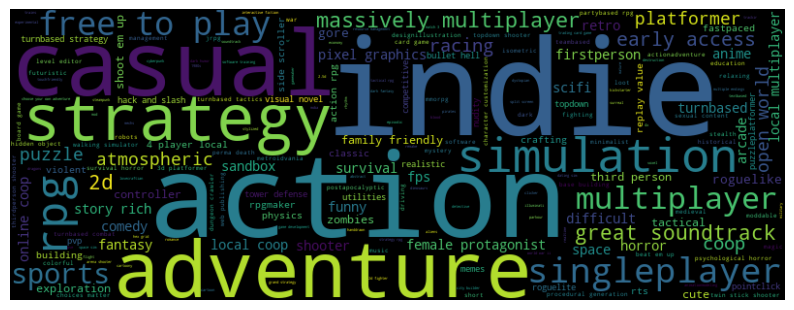

In [23]:
# Cuenta la frecuencia de cada tag
frecuencia_genero = df_steam_games['tags'].value_counts()

# Crea la nube de palabras
wordcloud = WordCloud(width=800, height=300, background_color='black').generate_from_frequencies(frecuencia_genero)

# Muestra la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

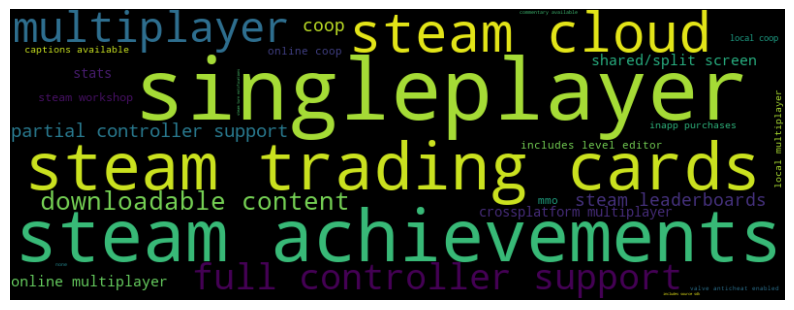

In [24]:
# Cuenta la frecuencia de cada spec
frecuencia_genero = df_steam_games['specs'].value_counts()

# Crea la nube de palabras
wordcloud = WordCloud(width=800, height=300, background_color='black').generate_from_frequencies(frecuencia_genero)

# Muestra la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [25]:
# Elimino los puntos de la columna 'developer'
df_steam_games['developer'] = df_steam_games['developer'].apply(lambda x: x.replace('.', '') if isinstance(x, str) else x)


In [26]:
# Elimino los caracteres especiales de la columna 'app_name'

df_steam_games['app_name'] = df_steam_games['app_name'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_steam_games['app_name'] = df_steam_games['app_name'].apply(lambda x: re.sub(r'\s+', ' ', x))

In [29]:
# Elimino palabras irrelevantes en la columna 'developer'
words_to_remove = [
    ' incferal interactive macferal interactive linux',
    ' mac amp linux',
    ' interactive mac',
    ' interactive macferal interactive linux',
    ' gamesaspyr macvirtual programming linux',
    ' softwareaspyr mac amp linux',
    ' interactive mac/linux',
    'incferal interactive macferal interactive linux '
]

def clean_developer_name(name):
    for word in words_to_remove:
        name = name.replace(word, '').strip()
    return name

In [30]:
df_steam_games['cleaned_developer_column'] = df_steam_games['developer'].apply(clean_developer_name)

In [31]:
df_steam_games['developer'] = df_steam_games['cleaned_developer_column']
df_steam_games.drop('cleaned_developer_column',axis=1, inplace=True)

In [33]:
df_steam_games.head(3)

,genres,app_name,tags,specs,price,id,developer,anio
0,action,lost summoner kitty,strategy,singleplayer,4.99,761140,kotoshiro,2018
1,action,lost summoner kitty,action,singleplayer,4.99,761140,kotoshiro,2018
2,action,lost summoner kitty,indie,singleplayer,4.99,761140,kotoshiro,2018


In [29]:
# Guardo el dataset procesado para su posterior uso
df_steam_games.to_parquet('df_steam_games_limpio_final.parquet')